# Visualization Prototype

This notebook protoypes the visualizations that will be on the website. First we import the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.constants import convert_temperature

Lets load the dataset that we created in the `EDA_ETL.ipynb` notebook.

In [2]:
data = pd.read_csv("sample_data.csv", index_col=0)
data_vel = data[[col for col in data.columns if "vel" in col]]
data_T = data[[col for col in data.columns if "T" in col]]
data_T = data_T.applymap(lambda x: convert_temperature(x, "K", "F"))

First we make a plot that shows the power history, as well as the 90% IQR of the wind speed at the different turbine locations. This plot shows the correlation between these two things that enables us to train a machine learnin model to predict the availability of wind power using the weather forecast simulations. In addition, in the full application, this plot will show the predicited future power availablity.

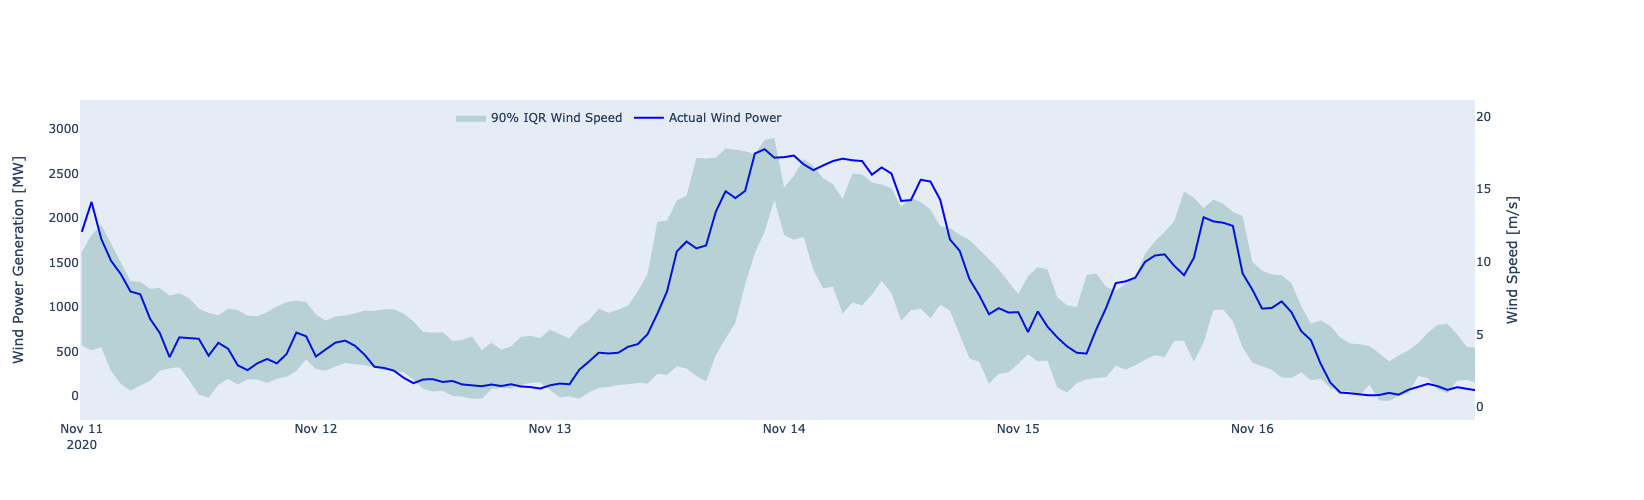

In [96]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(
        x=data.index,
        y=data["Wind"],
        line_color='blue',
        name='Actual Wind Power',
        hoverinfo="skip"))

fig.add_trace(
    go.Scatter(
        x=data.index,
        y=data_vel.quantile(0.05, axis=1),
        mode="lines",
        line=dict(width=0),
        showlegend=False,
        hoverinfo="skip"),
    secondary_y=True)

fig.add_trace(
    go.Scatter(
        x=data.index,
        y=data_vel.quantile(0.95, axis=1),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(0, 100, 80, 0.2)',
        fill='tonexty',
        name="90% IQR Wind Speed",
        hoverinfo="skip"),
    secondary_y=True)

fig.update_layout(
    width=1000,
    height=500,
    legend=dict(
        orientation="h",
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.25,
        bgcolor="rgba(0,0,0,0)")
)

fig.update_yaxes(title_text="Wind Power Generation [MW]",
                 secondary_y=False,
                 showgrid=False,
                 zeroline=False,
                 range=[np.min(data["Wind"]) - 0.1*np.ptp(data["Wind"]), np.max(data["Wind"]) + 0.2*np.ptp(data["Wind"])])

iqr = np.ptp(data_vel.quantile(0.95, axis=1) - data_vel.quantile(0.05, axis=1))
fig.update_yaxes(title_text="Wind Speed [m/s]",
                 secondary_y=True,
                 showgrid=False,
                 zeroline=False,
                 range=[np.min(data_vel.quantile(0.05, axis=1)) - 0.1*iqr, np.max(data_vel.quantile(0.95, axis=1)) + 0.2*iqr])
fig.update_xaxes(showgrid=False)

fig.update_traces(mode='lines')
fig.show()

Lets load the turbine metadata that we downloaded in the `EDA_ETL.ipynb` notebook.

In [4]:
turbine_data = pd.read_csv("turbine_metadata.csv", index_col=0)

We now make a heatmap that shows the wind speeds at the different turbine locations on a map. This image in the full application will have a time-slider that allows the user to visualize the wind at the turbines at different points in time. In addition, we will likely plot the full wind dataset in the form of a streamplot on top of this, if it doesn't slow down the plot in the browser and make it un-interactable.

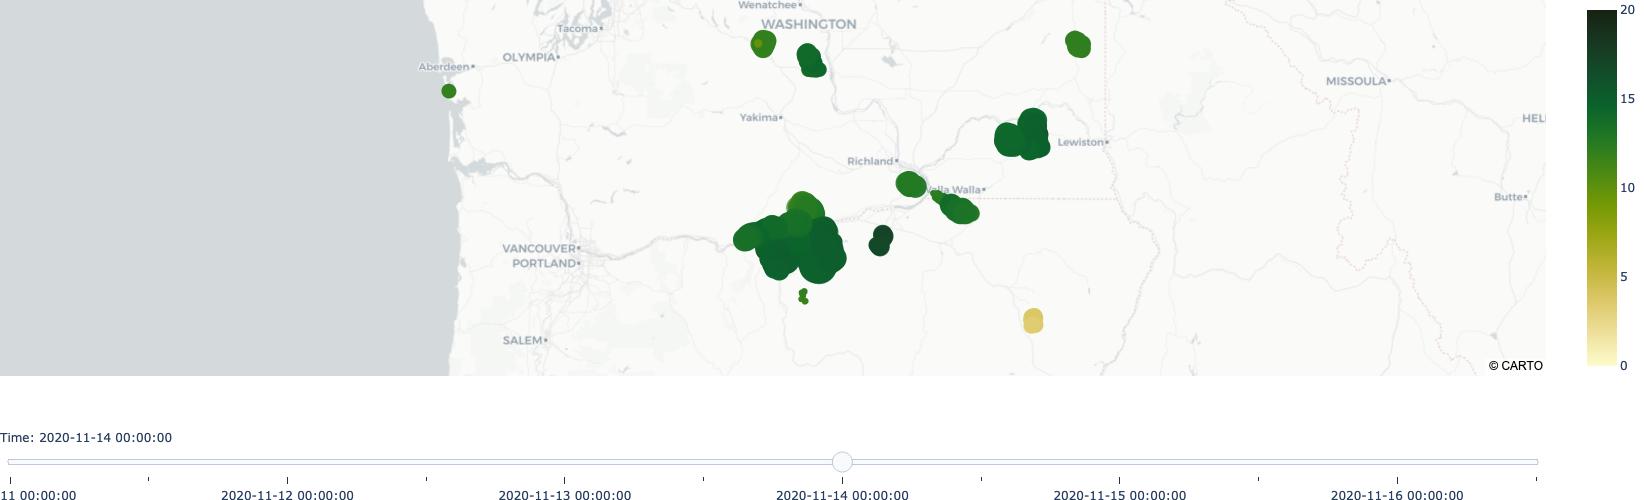

In [95]:
fig = go.Figure()

for i in range(0, data_vel.shape[0], 12):
    fig.add_trace(
        go.Scattermapbox(
            visible=False,
            lon = turbine_data['xlong'],
            lat = turbine_data['ylat'],
            mode="markers",
            customdata=turbine_data["t_hh"],
            marker=dict(
                size=turbine_data["t_cap"],
                sizeref=1e2,
                color=data_vel.iloc[i,:].to_numpy(),
                showscale=True,
                colorscale="speed",
                colorbar=dict(),
                cmin=0,
                cmax=20),
            hovertemplate="Rated Power Capacity: %{marker.size:,} kW<br>Turbine Hub Height: %{customdata}"),
        )
    
fig.data[-1].visible=True

steps = []
for i in range(len(fig.data)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)}],
        label=data.index[12*i]
    )
    step["args"][0]["visible"][i] = True
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Time: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_center_lon=180,
    width=1000,
    height=500,
    mapbox=dict(
        center=dict(
            lat=46,
            lon=-121
        ),
        zoom=6
    )
)

fig.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0})

fig.show()